In [70]:
# %load_ext iminizinc
%load_ext autoreload
%autoreload 2

from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
# import ipywidgets as widgets
from ipywidgets import *
from IPython.display import display
import IPython
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np

from datetime import datetime
# import talib
import pandas_ta as ta
# from talib.abstract import *
from math import *
from collections import OrderedDict
# import vectorbt as vbt    
import json
from decimal import *
getcontext().prec = 6
import seaborn as sns
from scipy.signal import find_peaks, peak_widths
import pickle
import scipy.interpolate as interpolate


import sys, os
sys.path.append(os.path.abspath('..'))
from research.pkg.lib import *


# import mplfinance as mpf
%matplotlib inline

plt.rcParams['lines.linewidth'] = 0.5 



The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
pair = 'BTC_USDT'
timeframe = '4h'

exchange = 'binance'
odf = pd.read_json(f'../freq-user-data/data/{exchange}/{pair}-{timeframe}.json'
# exchange = 'kucoin'
# odf = pd.read_json(f'../../freq-user-data/data/{exchange}/futures/{pair}-{timeframe}-futures.json'
).dropna().set_axis(['timestamp', 'open', 'high', 'low', 'close', 'volume'], axis=1
).assign(dtime=lambda x: pd.to_datetime(x['timestamp'], unit='ms', utc=False)
).set_index('dtime').sort_index()

print(odf.shape)
odf.head(4)

(12676, 6)


,timestamp,open,high,low,close,volume
dtime,,,,,,
2017-08-17 04:00:00,1502942400000,4261.48,4349.99,4261.32,4349.99,82.088865
2017-08-17 08:00:00,1502956800000,4333.32,4485.39,4333.32,4427.30,63.619882
2017-08-17 12:00:00,1502971200000,4436.06,4485.39,4333.42,4352.34,174.562001
2017-08-17 16:00:00,1502985600000,4352.33,4354.84,4200.74,4325.23,225.109716


In [3]:
wdf = odf.iloc[-30 * 6:,:]
wdf

,timestamp,open,high,low,close,volume
dtime,,,,,,
2023-05-03 12:00:00,1683115200000,28543.73,28583.33,28113.69,28311.51,13681.91671
2023-05-03 16:00:00,1683129600000,28311.52,28800.00,28211.08,28322.98,19116.31620
2023-05-03 20:00:00,1683144000000,28322.97,29266.66,28285.19,29026.16,14351.34164
2023-05-04 00:00:00,1683158400000,29026.16,29195.94,28950.98,29096.86,6023.39211
2023-05-04 04:00:00,1683172800000,29096.85,29237.73,29038.31,29058.19,5854.55975
...,...,...,...,...,...,...
2023-06-01 16:00:00,1685635200000,26894.47,27175.00,26656.00,26862.68,8974.24713
2023-06-01 20:00:00,1685649600000,26862.68,26942.98,26713.34,26817.93,3659.35611
2023-06-02 00:00:00,1685664000000,26817.93,27017.00,26505.00,27000.00,7016.04160


In [79]:
def plot_candles(wdf, ax):
    up, down = wdf[wdf.close >= wdf.open], wdf[wdf.close < wdf.open]
    col1,col2 = 'green','red'
    width, width2 = .1, .01
    # Plotting up prices of the stock
    ax.bar(up.index, up.close-up.open, width, bottom=up.open, color=col1)
    ax.bar(up.index, up.high-up.close, width2, bottom=up.close, color=col1)
    ax.bar(up.index, up.low-up.open, width2, bottom=up.open, color=col1)
    # Plotting down prices of the stock
    ax.bar(down.index, down.close-down.open, width, bottom=down.open, color=col2)
    ax.bar(down.index, down.high-down.open, width2, bottom=down.open, color=col2)
    ax.bar(down.index, down.low-down.close, width2, bottom=down.close, color=col2)   


In [98]:
fibs = np.array([0, 0.236, 0.382, 0.5, 0.618, 0.786, 1])
# dfibs = pd.Series(fibs, index=wdf.index)

xx = np.linspace(0, 1, 100)

a = np.array(
    [ [fib, 0] for fib in fibs] + [[z, (-1) ** (i) * z * 0.1 ] for i,z in enumerate((fibs[1:] + fibs[:-1])/2)]
    )
ax, ay = a[a[:, 0].argsort()].T

spline = interpolate.InterpolatedUnivariateSpline(ax, ay)


@interact(x0=(0,wdf.shape[0], 1),x1=(0,wdf.shape[0], 1),x2=(0,wdf.shape[0], 1),xx=(0,wdf.shape[0], 1))
def printer(x0=24,x1=52,x2=119,xx=wdf.shape[0] // 2):
    wlen = wdf.shape[0]
    x_last = wlen - 1
    fig = plt.figure(figsize=(20,9))
    axn = fig.subplots(3,1, sharex=True, height_ratios=[1,1,1])
    ax, ax1, ax2 = axn
    y = wdf.close.values
    idx0, idx1, idx2, idxx = wdf.iloc[[x0,x1,x2, xx]].index.values
    y0, y1, y2 = wdf.close.iloc[[x0,x1,x2]]

    # y_d = y2 - y0
    k = (y2 - y0) / (x2 - x0)
    
    y_lower = (pd.Series(range(wdf.shape[0])) - x1) * k + y1
    y_upper = (pd.Series(range(wdf.shape[0])) - x0) * k + y0


    y_tran = y - y_upper
    y_tran.index = wdf.index
    yt0, yt1, yt2 = y_tran.iloc[[x0,x1,x2]]

    # y_fibs =  [y_lower + (y_upper - y_lower) * fib for fib in fibs] +  [y_lower + (y_upper - y_lower) * - fib for fib in fibs] +  [y_lower + (y_upper - y_lower) * (1 + fib) for fib in fibs]
    y_fibs = [y_lower + (y_upper - y_lower) * fib for fib in fibs] 
    # wdf.close.plot(ax=ax,lw=0.5)
    # ax.set_yscale('symlog')

    # y_d = 
    plt.xticks(rotation=30, ha='right')
    for axs in axn: axs.axvline(idx0, c='r'); axs.axvline(idx1, c='g'); axs.axvline(idx2, c='b');
    for axs in axn: axs.axvline(idxx, linestyle='dashed', c='black');
    ax.axhline(y0, linestyle='dashed');ax.axhline(y1, linestyle='dashed');ax.axhline(y2, linestyle='dashed');
    
    ax.plot(wdf.index[[0,-1]].values,y_upper.iloc[[0,-1]].values, c='maroon')
    ax.plot(wdf.index[[0,-1]].values,y_lower.iloc[[0,-1]].values, c='maroon')

    axtw = ax1.twinx()
    # y_tran.plot(ax=axtw, c='g')
    # axtw.axhline(y_tran[x0]);axtw.axhline(y_tran[x1])
    y_norm = pd.Series( y_tran / yt1, index=wdf.index)

    # y_norm.plot(ax=axtw, c='g', alpha=0.2)
    # y_norm = pd.Series(np.sin( y / y_tran[x1]), index=wdf.index) 
    # y_norm_p = np.cos( - pi / 2 + y_norm * pi)  #/ 2 + 0.5
    y_norm_p = 1- (y_norm  % 1)
    y_norm_p.plot(ax=ax1, c='r')
    # ax1.grid(); ax.grid()
    # dfibs.plot(ax=ax1)

    axtw1 = ax1.twinx()
    # axtw1.plot(wdf.index, spline(y_norm_p), c='g')
    ax2.plot(wdf.index, spline(y_norm_p), c='g')
    ax2.axhline()
    for fib in y_fibs:
        ax.plot(wdf.index[[0,-1]].values,fib.iloc[[0,-1]].values, c='maroon')
    for fib in fibs:
        ax1.axhline(fib)

    
    plot_candles(wdf,ax)
    ax.set_ylim([y.min(), y.max()])
        # ax1.axhline(-fib)


interactive(children=(IntSlider(value=24, description='x0', max=180), IntSlider(value=52, description='x1', ma…

In [112]:
fibs = [0, 0.236, 0.382, 0.5, 0.618, 0.786, 1]

In [178]:
y = wdf.close.values
xx=0
x0,x1,x2 = 20, 30, 50
# idx0, idx1, idx2, idxx = wdf.iloc[[x0,x1,x2, xx]].index.values
y0, y1, y2 = wdf.close.iloc[[x0,x1,x2]]

# y_d = y2 - y0
k = (y2 - y0) / (x2 - x0)

y_upper = ((pd.Series(range(wdf.shape[0])) - x0) * k + y0)
y_upper.iloc[[0,-1]].values

array([12825.58 , 48204.214])

### Fit fib-levels with B-Splines

t: [0.    0.    0.    0.    0.382 0.5   0.618 1.    1.    1.    1.   ]
c: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
k: 3



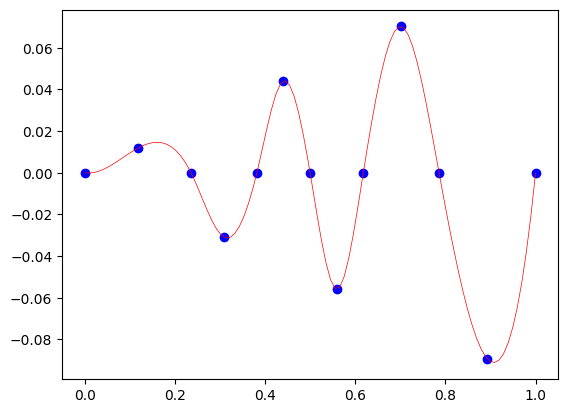

In [99]:
import numpy as np
import scipy.interpolate as interpolate
import matplotlib.pyplot as plt
from numpy.polynomial import polynomial as P
from numpy.polynomial.hermite import hermfromroots, hermval
from scipy.fft import fft, ifft, fftfreq, fftshift

fibs = np.array([0, 0.236, 0.382, 0.5, 0.618, 0.786, 1])
x = fibs 
y = np.zeros(len(x))

t, c, k = interpolate.splrep(fibs, y, s=0, k=3)
print('''\
t: {}
c: {}
k: {}
'''.format(t, c, k))
N = 100
xmin, xmax = x.min(), x.max()
xx = np.linspace(xmin, xmax, N)

a = np.array(
    [ [fib, 0] for fib in fibs] + [[z, (-1) ** (i) * z * 0.1 ] for i,z in enumerate((fibs[1:] + fibs[:-1])/2)]
    )
ax, ay = a[a[:, 0].argsort()].T

spline = interpolate.InterpolatedUnivariateSpline(ax, ay)

plt.plot(ax, ay, 'bo', label='Original points')

# plt.plot(x, y, 'bo', label='Original points')
plt.plot(xx, spline(xx), 'r', label='BSpline')
# plt.grid()
# plt.legend(loc='best')
# plt.show()

In [63]:

a = np.array(
    [ [fib, 0] for fib in fibs] + [[z, (-1) ** (i) ] for i,z in enumerate((fibs[1:] + fibs[:-1])/2)]
    )
ax, ay = a[a[:, 0].argsort()].T
ay

array([ 0.,  1.,  0., -1.,  0.,  1.,  0., -1.,  0.,  1.,  0., -1.,  0.])